# DevOps for ML

This Notebook is based on publicly available github repository about Azure ML Service: https://github.com/Azure/MachineLearningNotebooks

Make sure you installed required libs, by running cell below

In [ ]:
!pip install -r requriements.txt

In [19]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [27]:
import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.21


In [21]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


# Azure Machine Learning Workspace
Before going further, we need to create a Azure Machine Learning Services (AMLS).
To do so, jump to the portal and create a workspace:

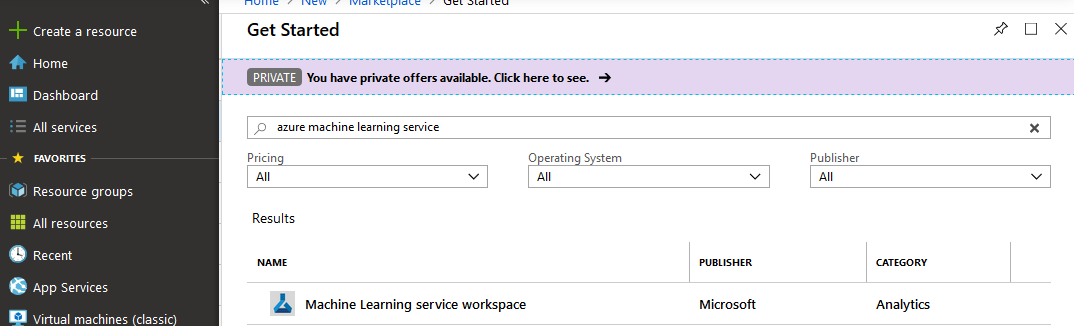

Now let's create a workspace configuration file. We will use that file to authenticate and run distributed learning jobs, submit models to model registry and build containers for later deployments.

In [22]:
import json
   
configFile = {
    "subscription_id": "<put your subscription id here>",
    "resource_group": "<resource group name>",
    "workspace_name": "<workspace name>",
    "location": "<location, e.g. west europe or others>",
    }

with open('config.json', 'w') as outfile:  
    json.dump(configFile, outfile)

In [23]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Found the config file in: C:\Users\uanass\Desktop\localrepos\ML DevOps\config.json
Workspace name: mlworkspace
Azure region: westeurope
Subscription id: a9069517-0f21-4c1f-9931-33e6ebe52ead
Resource group: mlworkspacerg


# Create an Azure ML Experiment

Let's create an experiment named "tf-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [24]:
from azureml.core import Experiment

script_folder = './tf-mnist-devops'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist-devops')

Now let's download our MNIST dataset

In [8]:
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')

('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x20e9d6561d0>)

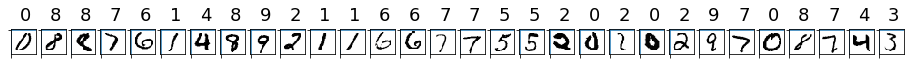

In [9]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

# Upload MNIST dataset to default datastore

Each workspace works with a datastore - Blob Storage or Azure Files, which Run can access and transfer data to compute target.
For example, running this experiment locally on PC will require to tranfer the data to cloud storage. 

In this example we use default datastore, provided with workspace.

In [10]:
ds = ws.get_default_datastore()

In [11]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_f209c0f2805c431eb6a2ab671a9b7a45

# Provisioning the Compute Cluster

To train the model we will use cluster of 4 NC6 GPU VMs. You can add additional parameters, such as vmPriority: "Low Priority" to decrease costs.

In [12]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2018-12-20T15:28:50.116000+00:00', 'errors': None, 'creationTime': '2018-12-20T14:24:29.273175+00:00', 'modifiedTime': '2018-12-20T14:28:54.540859+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


To check available clusters run this command

In [13]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

gpucluster AmlCompute Succeeded
cpucluster AmlCompute Succeeded


# Training Script

Each time you want to initialize a distributed training for a model you are working on, you need to arrange your training script in a separate file. The good part is - you can do it staight from the Jupyter Notebooks by running

```%%writefile filename```

In [ ]:

# Add %%writefile training.py to create a training file and use it later. 
# In this example script already exist as a separate file

import numpy as np
import argparse
import os
import tensorflow as tf
import tempfile

from azureml.core import Run
from utils import load_data

print("TensorFlow version:", tf.VERSION)



parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=100,
                    help='# of neurons in the first layer')
parser.add_argument('--second-layer-neurons', type=int, dest='n_hidden_2', default=100,
                    help='# of neurons in the second layer')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.01, help='learning rate')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'mnist')

print('training dataset is stored here:', data_folder)

X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0

y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')
training_set_size = X_train.shape[0]

os.makedirs('./outputs/model', exist_ok=True)

n_inputs = 28 * 28
n_h1 = args.n_hidden_1
n_h2 = args.n_hidden_2
n_outputs = 10
learning_rate = args.learning_rate
n_epochs = 20
batch_size = args.batch_size

with tf.name_scope('network'):
    # construct the DNN
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name='y')
    h1 = tf.layers.dense(X, n_h1, activation=tf.nn.relu, name='h1')
    h2 = tf.layers.dense(h1, n_h2, activation=tf.nn.relu, name='h2')
    output = tf.layers.dense(h2, n_outputs, name='output')

with tf.name_scope('train'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output)
    loss = tf.reduce_mean(cross_entropy, name='loss')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(output, y, 1)
    acc_op = tf.reduce_mean(tf.cast(correct, tf.float32))



init = tf.global_variables_initializer()
saver = tf.train.Saver()

# start an Azure ML run
run = Run.get_context()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})

        # log accuracies
        run.log('training_acc', np.float(acc_train))
        run.log('validation_acc', np.float(acc_val))
        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    

    run.log('final_acc', np.float(acc_val))


    with open("./outputs/model/graph.proto", "wb") as file:
        graph = tf.get_default_graph().as_graph_def(add_shapes=True)
        file.write(graph.SerializeToString())

    graph_location = tempfile.mkdtemp()
    print('Saving graph to: %s' % graph_location)
    train_writer = tf.summary.FileWriter(graph_location)
    train_writer.add_graph(tf.get_default_graph())

    # files saved in the "./outputs" folder are automatically uploaded into run history

    #saver.save(sess, './outputs/model/mnist-tf.model')
    saver.save(sess, "./outputs/model/model.ckpt")

# Copy training script into script folder

Below you can see training script loaded to script folder

In [17]:
%%writefile script_copy.py
import shutil

# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

Writing script_copy.py


# Azure ML concepts
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument --data_folder which specifies the file system folder in which the script can find the MNIST data 

 ```parser = argparse.ArgumentParser()```
 
 ```parser.add_argument('--data_folder')```
 
 
2. The script is accessing the Azure ML Run object by executing run = Run.get_context(). Further down the script is using the run to report the training accuracy and the validation accuracy as training progresses.

 ```run.log('training_acc', np.float(acc_train))```
 
 ```run.log('validation_acc', np.float(acc_val))```
 
 
3. When running the script on Azure ML, you can write files out to a folder ./outputs that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

# DevOps

After we validated that our model works, we want to initialize our CI/CD pipelines that will end up updating our container without any downtime. 
We will start by switching to Azure DevOps and doing a pull request from our branch to master, which will trigger the final full data training and deployment to staging enviroment.

Please got to Readme.md on GitHub to continue